In [1]:
#import libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from pathlib import Path
from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

In [3]:
#upload data from drive
from google.colab import drive
import PIL.Image
drive.mount('/content/drive', force_remount=True)

#there are 400+ images for now
c_images = os.chdir('/content/drive/MyDrive/JOADEM Corporation (LA) - Predicting Structural Defects in Construction Projects Using Machine Learning/Data/Pavement Practice Folder/P/CP')
u_images = os.chdir('/content/drive/MyDrive/JOADEM Corporation (LA) - Predicting Structural Defects in Construction Projects Using Machine Learning/Data/Pavement Practice Folder/P/UP')
c_path = '/content/drive/MyDrive/JOADEM Corporation (LA) - Predicting Structural Defects in Construction Projects Using Machine Learning/Data/Pavement Practice Folder/P/CP'
u_path = '/content/drive/MyDrive/JOADEM Corporation (LA) - Predicting Structural Defects in Construction Projects Using Machine Learning/Data/Pavement Practice Folder/P/UP'


Mounted at /content/drive


In [4]:
#create dataframes
def generate_df(image_dir, label):
    filepaths = pd.Series(list(image_dir.glob('*.jpg')), name='Filepath').astype(str)
    labels = pd.Series(label, name='Label', index=filepaths.index)
    df = pd.concat([filepaths, labels], axis=1)
    return df



In [5]:
c_path = Path('/content/drive/MyDrive/JOADEM Corporation (LA) - Predicting Structural Defects in Construction Projects Using Machine Learning/Data/Pavement Practice Folder/P/CP')
u_path = Path('/content/drive/MyDrive/JOADEM Corporation (LA) - Predicting Structural Defects in Construction Projects Using Machine Learning/Data/Pavement Practice Folder/P/UP')


In [6]:
cracked_df = generate_df(c_path, label="CRACKED")
uncracked_df = generate_df(u_path, label="UNCRACKED")

all_df = pd.concat([cracked_df, uncracked_df], axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
all_df

,Filepath,Label
0,/content/drive/MyDrive/JOADEM Corporation (LA)...,UNCRACKED
1,/content/drive/MyDrive/JOADEM Corporation (LA)...,CRACKED
2,/content/drive/MyDrive/JOADEM Corporation (LA)...,CRACKED
3,/content/drive/MyDrive/JOADEM Corporation (LA)...,UNCRACKED
4,/content/drive/MyDrive/JOADEM Corporation (LA)...,UNCRACKED
...,...,...
835,/content/drive/MyDrive/JOADEM Corporation (LA)...,UNCRACKED
836,/content/drive/MyDrive/JOADEM Corporation (LA)...,UNCRACKED
837,/content/drive/MyDrive/JOADEM Corporation (LA)...,CRACKED
838,/content/drive/MyDrive/JOADEM Corporation (LA)...,CRACKED


In [7]:
train_df, test_df = train_test_split(
    all_df.sample(800, random_state=1),
    train_size=0.7,
    shuffle=True,
    random_state=1
)

In [8]:
#load image data
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)



In [9]:
train_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
     shuffle=True,
    seed=42,
    subset='validation'
)

test_data = train_gen.flow_from_dataframe(
    test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False,
    seed=42
)

Found 448 validated image filenames belonging to 2 classes.
Found 112 validated image filenames belonging to 2 classes.
Found 240 validated image filenames belonging to 2 classes.


In [10]:
#training
inputs = tf.keras.Input(shape=(120, 120, 3))
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print(model.summary())


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 118, 118, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 59, 59, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 57, 57, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 28, 28, 32)        0         
 g2D)                                                            
                                                                 
 global_average_pooling2d (  (None, 32)                0     

Use this to improve the layers:
https://cnvrg.io/cnn-tensorflow/


In [11]:
#fit model onto data
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
14/14 [==============================] - 75s 5s/step - loss: 0.6927 - accuracy: 0.5000 - val_loss: 0.6945 - val_accuracy: 0.4643
Epoch 2/100
14/14 [==============================] - 6s 403ms/step - loss: 0.6885 - accuracy: 0.5179 - val_loss: 0.6934 - val_accuracy: 0.4643
Epoch 3/100
14/14 [==============================] - 9s 671ms/step - loss: 0.6875 - accuracy: 0.5179 - val_loss: 0.6903 - val_accuracy: 0.4643
Epoch 4/100
14/14 [==============================] - 8s 576ms/step - loss: 0.6869 - accuracy: 0.6094 - val_loss: 0.6869 - val_accuracy: 0.4643
Epoch 5/100
14/14 [==============================] - 7s 453ms/step - loss: 0.6853 - accuracy: 0.5179 - val_loss: 0.6887 - val_accuracy: 0.4643
Epoch 6/100
14/14 [==============================] - 5s 329ms/step - loss: 0.6832 - accuracy: 0.5848 - val_loss: 0.6797 - val_accuracy: 0.8214
Epoch 7/100
14/14 [==============================] - 7s 502ms/step - loss: 0.6813 - accuracy: 0.5357 - val_loss: 0.6868 - val_accuracy: 0.4643
E

In [12]:
#visualize results
fig = px.line(
    history.history,
    y=['loss', 'val_loss'],
    labels={'index': "Epoch", 'value': "Loss"},
    title="Training and Validation Loss Over Time"
)

fig.show()

In [13]:
#results

def evaluate_model(model, test_data):

    results = model.evaluate(test_data, verbose=0)
    loss = results[0]
    acc = results[1]

    print("    Test Loss: {:.5f}".format(loss))
    print("Test Accuracy: {:.2f}%".format(acc * 100))

    y_pred = np.squeeze((model.predict(test_data) >= 0.5).astype(np.int))
    cm = confusion_matrix(test_data.labels, y_pred)
    clr = classification_report(test_data.labels, y_pred, target_names=["UNCRACKED", "CRACKED"])

    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
    plt.xticks(ticks=np.arange(2) + 0.5, labels=["UNCRACKED", "CRACKED"])
    plt.yticks(ticks=np.arange(2) + 0.5, labels=["UNCRACKED", "CRACKED"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    print("Classification Report:\n----------------------\n", clr)

    Test Loss: 0.48543
Test Accuracy: 83.33%
8/8 [==============================] - 2s 154ms/step


<ipython-input-18-fda16a2967dc>:12: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



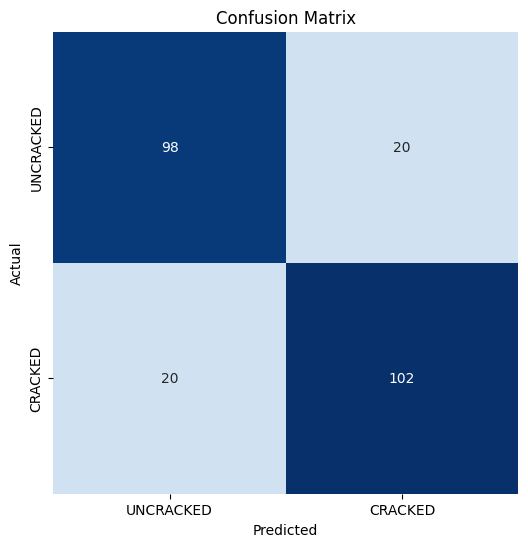

Classification Report:
----------------------
               precision    recall  f1-score   support

   UNCRACKED       0.83      0.83      0.83       118
     CRACKED       0.84      0.84      0.84       122

    accuracy                           0.83       240
   macro avg       0.83      0.83      0.83       240
weighted avg       0.83      0.83      0.83       240



In [ ]:
evaluate_model(model, test_data)

Not bad, it reached over 80% accuracy. Now to boost it to the 90s and we should be good for this model, then we can increase the size of the data again.